<a href="https://colab.research.google.com/github/veillette/jupyterNotebooks/blob/main/Classical%20Mechanics/twoStageRocketPropulsion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Stage Rocket Launch Simulation

This notebook implements a physics-based simulation of a multi-stage rocket launch, modeling the complex interplay of forces and mass changes during vertical ascent through Earth's atmosphere. The simulation accounts for varying gravitational forces, atmospheric drag, stage separation events, and continuous propellant consumption.

## Rocket Configuration

The simulated rocket begins with an initial mass of 740 000 kg and generates 7.5 MN of thrust through its main engines. The rocket's exhaust velocity is 2 900 m/s, and it presents a cross-sectional area of 5.0 m² to the atmosphere, with a drag coefficient of 0.5.

The rocket's mass is distributed across multiple stages. The first stage and second stage each carry 40% of the initial mass as propellant (296 000 kg each). Additional strap-on boosters contribute 5% of the initial mass (37 000 kg), while the remaining 15% (111 000 kg) represents the rocket's dry mass including payload.

## Physical Models

The simulation employs realistic physical models for environmental forces. Gravitational acceleration varies with altitude according to the inverse square law, starting from 9.80 m/s² at sea level and decreasing as the rocket gains altitude. This calculation uses Earth's radius of 6 371 km as a reference.

Atmospheric density follows an exponential decay model, beginning at 1.15 kg/m³ at sea level and decreasing with height. This atmospheric model affects the drag forces experienced by the rocket during ascent.

The rocket experiences three primary forces during flight: thrust from the engines (calculated as the product of propellant mass flow rate and exhaust velocity), gravitational force (varying with altitude), and atmospheric drag (proportional to the square of velocity and local air density).

## Computational Implementation

The simulation advances in time steps of 0.1 seconds over a total duration of 780 seconds. It employs the Euler-Cromer integration method to update the rocket's position, velocity, and mass. Stage separation occurs automatically based on propellant consumption, with the simulation monitoring mass thresholds to trigger booster separation and engine cutoff events.

## Performance Metrics

Throughout the simulation, we track several key performance metrics: the maximum altitude achieved, peak velocity, final mass after propellant consumption, maximum acceleration experienced, and the time required to reach space (defined as 100 km altitude).


In [43]:
import matplotlib.pyplot as plt # import the "pyplot" library as the "plt" handle
import numpy as np # import the "numpy" library as the "np" handle

In [44]:
reset()

Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.


In [45]:
def g(altitude):
    """Calculate gravitational acceleration at given altitude."""
    g0 = 9.80  # gravitational acceleration at sea level (m/s^2)
    earth_radius = 6.371e6  # Earth's radius in meters
    return g0 * (earth_radius / (earth_radius + altitude))**2

In [46]:
def rho(altitude):
     """Calculate air density at given altitude."""
     rhoSurface = 1.15 # kg/m^3
     molecularMass = 28*1.16*10**(-27) # molecular mass of nitrogen (kg)
     boltzmannConstant = 1.38*10**(-23) #  in J/K
     temperature = 300 # in Kelvin
     gravitationalPotentialEnergy= molecularMass*g(altitude)*altitude  # in J
     thermalEnergy = boltzmannConstant* temperature; # in J
     rho = rhoSurface*np.exp(- gravitationalPotentialEnergy/thermalEnergy)  # in kg/m^3
     return rho

In [47]:
def calculate_forces(mass, altitude, velocity, stage_active):
    """Calculate all forces acting on the rocket."""
    # Rocket parameters
    thrust_force = 7.5e6  # N
    exhaust_velocity = 2900  # m/s
    cross_section = 5.0  # m^2
    drag_coefficient = 0.5

    # Calculate thrust (only when stage is active)
    thrust = thrust_force if stage_active else 0

    # Calculate other forces
    gravity = -mass * g(altitude)
    drag = -0.5 * drag_coefficient * rho(altitude) * cross_section * velocity**2

    return thrust, gravity, drag

In [48]:
def update_state(state, dt):
    """Update rocket state for one timestep."""
    altitude, velocity, mass = state

    # Rocket mass parameters
    initial_mass = 7.4e5
    propellant_rate = 7.5e6 / 2900  # thrust_force / exhaust_velocity
    first_stage_propellant = 0.40 * initial_mass
    first_stage_boosters = 0.05 * initial_mass
    second_stage_propellant = 0.40 * initial_mass

    # Check if stage is still active
    stage_active = mass > (initial_mass - first_stage_propellant -
                          first_stage_boosters - second_stage_propellant)

    # Calculate forces and acceleration
    thrust, gravity, drag = calculate_forces(mass, altitude, velocity, stage_active)
    net_force = thrust + gravity + drag
    acceleration = net_force / mass

    # Update position and velocity
    new_altitude = altitude + velocity * dt + 0.5 * acceleration * dt**2
    new_velocity = velocity + acceleration * dt

    # Update mass
    new_mass = mass
    if stage_active:
        new_mass -= propellant_rate * dt

        # Check for booster separation
        if (new_mass < (initial_mass - first_stage_propellant) and
            new_mass > (initial_mass - first_stage_propellant - first_stage_boosters)):
            new_mass -= first_stage_boosters
            print(f"Ejecting boosters at altitude = {new_altitude/1000:.1f}km")

    return (new_altitude, new_velocity, new_mass)

In [49]:
def simulate_rocket(duration=780, dt=0.1):
    """Simulate rocket launch and return trajectory data."""
    # Initial conditions
    initial_state = (0, 0, 7.4e5)  # (altitude, velocity, mass)
    time_points = np.arange(0, duration, dt)

    # Generate all states using list comprehension
    states = [initial_state]
    [states.append(update_state(states[-1], dt)) for _ in time_points[1:]]

    # Unzip states into separate arrays using zip and list comprehension
    altitudes, velocities, masses = zip(*states)

    return time_points, np.array(altitudes), np.array(velocities), np.array(masses)

In [50]:
# Run simulation
times, altitudes, velocities, masses = simulate_rocket()

# Print results
print(f"\nSimulation Results:")
print(f"Maximum altitude: {max(altitudes)/1000:.1f} km")
print(f"Maximum velocity: {max(velocities):.1f} m/s")
print(f"Final mass: {masses[-1]:.1f} kg")

# Optional: Calculate interesting statistics using list comprehensions
max_acceleration = max([abs(v2 - v1) / 0.1 for v1, v2 in zip(velocities[:-1], velocities[1:])])
time_to_space = next(i * 0.1 for i, alt in enumerate(altitudes) if alt > 100000)  # Time to reach 100km

print(f"Maximum acceleration: {max_acceleration:.1f} m/s²")
print(f"Time to reach space (100km): {time_to_space:.1f} s")

Ejecting boosters at altitude = 13.3km

Simulation Results:
Maximum altitude: 686.2 km
Maximum velocity: 3013.7 m/s
Final mass: 110758.6 kg
Maximum acceleration: 58.2 m/s²
Time to reach space (100km): 204.2 s


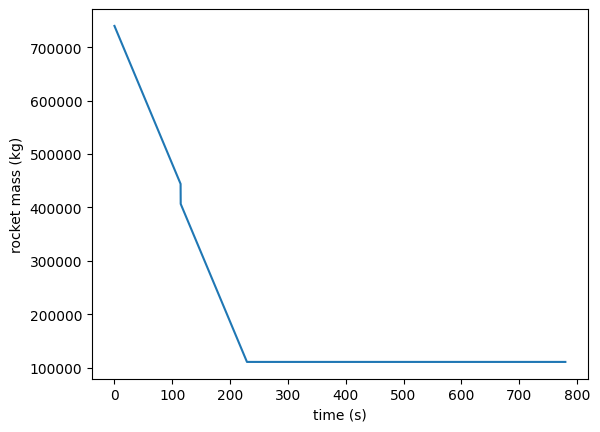

In [51]:
plt.plot(times,masses)
plt.ylabel( 'rocket mass (kg)')
plt.xlabel( 'time (s)')
plt.show()


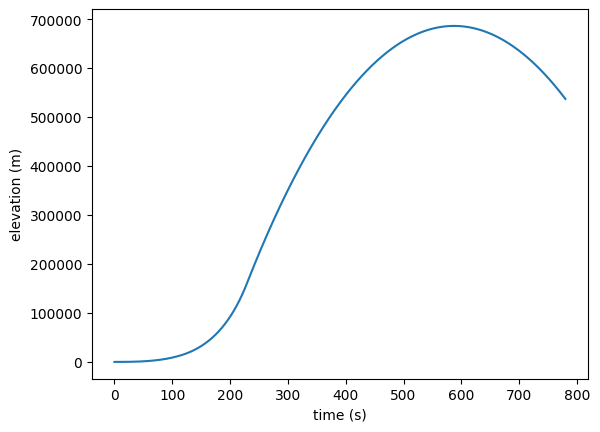

In [52]:
plt.plot(times,altitudes)
plt.ylabel( 'elevation (m)')
plt.xlabel( 'time (s)')
plt.show()

In [53]:
maximumHeight=np.max(altitudes)
print( f'maximum height of the rocket {maximumHeight/1000:.2f}  km')

maximum height of the rocket 686.17  km
